# Installing and Importing necessary libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from itertools import product
from joblib import Parallel, delayed
import random


# collecting Historical bitcoin data from yahoo finance

In [23]:
# Step 1: Download Bitcoin data from Yahoo Finance
def download_bitcoin_data(ticker='BTC-USD', start_date='2013-01-04', end_date='2021-02-10'):
    # Download data
    bitcoin_data = yf.download(ticker, start=start_date, end=end_date)
    # Ensure the index is a datetime object
    bitcoin_data.index = pd.to_datetime(bitcoin_data.index)
    return bitcoin_data

# Download the data
bitcoin_data = download_bitcoin_data()

# Display the first few rows of the data
print(bitcoin_data.head())



[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100  


# Data preprocessing

In [24]:
# Check if the index is already datetime
if not pd.api.types.is_datetime64_any_dtype(bitcoin_data.index):
    bitcoin_data.index = pd.to_datetime(bitcoin_data.index)

# Check for duplicates or missing dates
print("Index Info:")
print(bitcoin_data.index)

# Ensure there are no duplicate or missing dates
if bitcoin_data.index.duplicated().any():
    print("Duplicates found in index. Removing duplicates.")
    bitcoin_data = bitcoin_data[~bitcoin_data.index.duplicated()]

# Display summary
print("Bitcoin Data Summary:")
print(bitcoin_data.info())


Index Info:
DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03',
               '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07',
               '2021-02-08', '2021-02-09'],
              dtype='datetime64[ns]', name='Date', length=2338, freq=None)
Bitcoin Data Summary:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2338 entries, 2014-09-17 to 2021-02-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2338 non-null   float64
 1   High       2338 non-null   float64
 2   Low        2338 non-null   float64
 3   Close      2338 non-null   float64
 4   Adj Close  2338 non-null   float64
 5   Volume     2338 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 192.4 KB
None


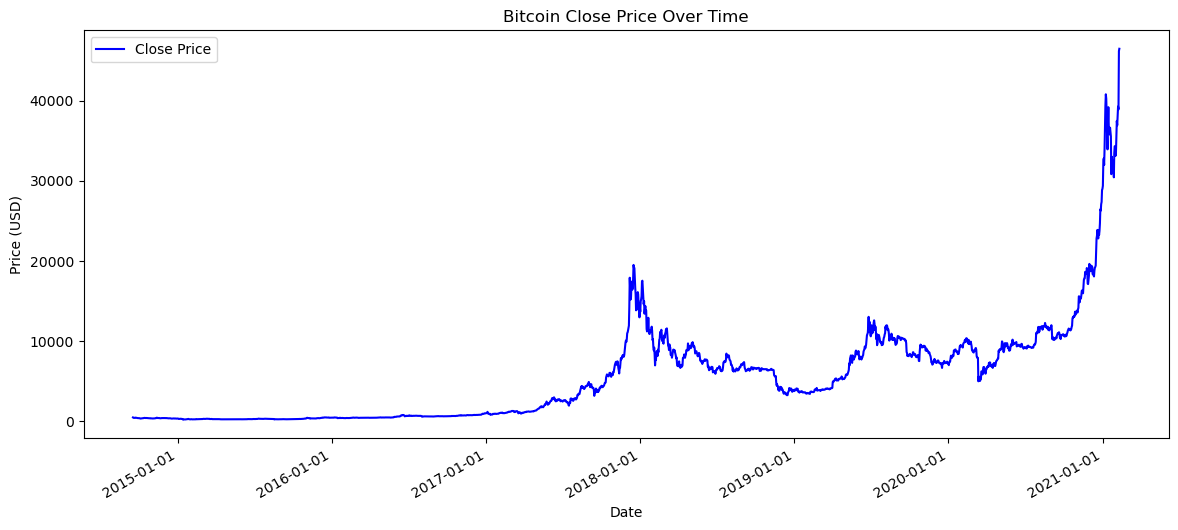

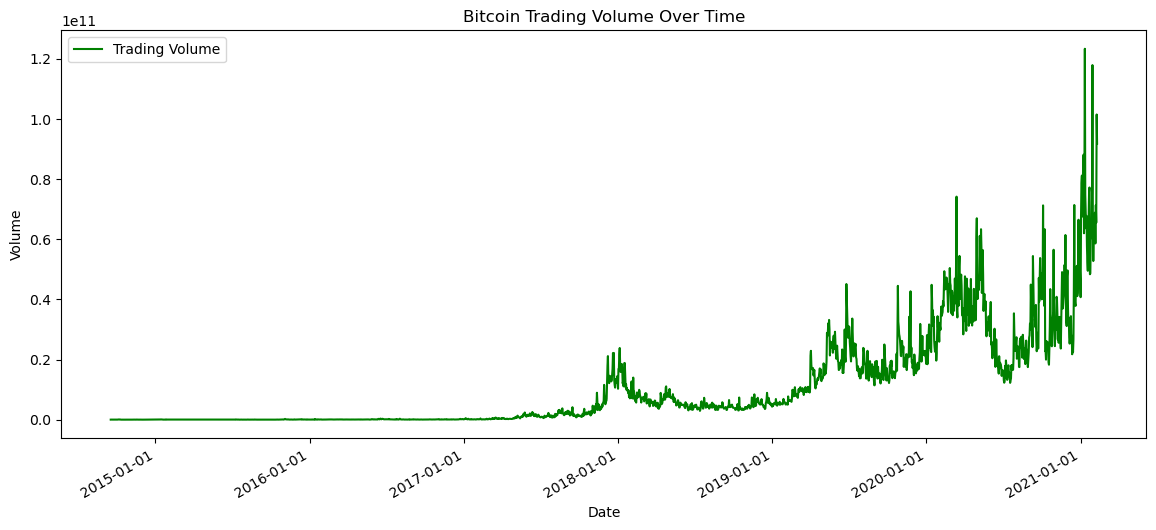

In [25]:
# Plot the closing prices
plt.figure(figsize=(14, 6))
plt.plot(bitcoin_data.index, bitcoin_data['Close'], label='Close Price', color='b')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

# Format x-axis to display proper dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.show()

# Plot the trading volume
plt.figure(figsize=(14, 6))
plt.plot(bitcoin_data.index, bitcoin_data['Volume'], label='Trading Volume', color='g')
plt.title('Bitcoin Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

# Format x-axis to display proper dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.show()


In [26]:
# Step 3: Clean the data
def clean_data(df):
    # Drop any rows with missing values
    df = df.dropna()

    # Reset the index to keep a clean DataFrame
    df = df.reset_index()

    # Rename columns for better readability
    df.rename(columns={
        'Date': 'Date',
        'Open': 'Open_Price',
        'High': 'High_Price',
        'Low': 'Low_Price',
        'Close': 'Close_Price',
        'Adj Close': 'Adjusted_Close_Price',
        'Volume': 'Trading_Volume'
    }, inplace=True)

    # Set Date as the index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df

# Clean the data
cleaned_bitcoin_data = clean_data(bitcoin_data)

# Display the cleaned data
print(cleaned_bitcoin_data.head())


            Open_Price  High_Price   Low_Price  Close_Price  \
Date                                                          
2014-09-17  465.864014  468.174011  452.421997   457.334015   
2014-09-18  456.859985  456.859985  413.104004   424.440002   
2014-09-19  424.102997  427.834991  384.532013   394.795990   
2014-09-20  394.673004  423.295990  389.882996   408.903992   
2014-09-21  408.084991  412.425995  393.181000   398.821014   

            Adjusted_Close_Price  Trading_Volume  
Date                                              
2014-09-17            457.334015        21056800  
2014-09-18            424.440002        34483200  
2014-09-19            394.795990        37919700  
2014-09-20            408.903992        36863600  
2014-09-21            398.821014        26580100  


# Feature Engineering

In [27]:
# Step 4: Feature Engineering
def add_technical_indicators(df):
    # Add Simple Moving Average (SMA)
    df['SMA_14'] = df['Close_Price'].rolling(window=14).mean()

    # Add Exponential Moving Average (EMA)
    df['EMA_14'] = df['Close_Price'].ewm(span=14, adjust=False).mean()

    # Add Relative Strength Index (RSI)
    delta = df['Close_Price'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # Add Stochastic Oscillator (StochK)
    low_14 = df['Low_Price'].rolling(window=14).min()
    high_14 = df['High_Price'].rolling(window=14).max()
    df['StochK'] = 100 * ((df['Close_Price'] - low_14) / (high_14 - low_14))

    # Add Stochastic Oscillator's Moving Average (StochD)
    df['StochD'] = df['StochK'].rolling(window=3).mean()

    # Add MACD
    ema_12 = df['Close_Price'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close_Price'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Drop any rows with missing values after adding indicators
    df = df.dropna().reset_index()

    # Ensure index is reset and datetime aligned
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df

# Add technical indicators to the cleaned data
enhanced_bitcoin_data = add_technical_indicators(cleaned_bitcoin_data)

# Display the enhanced data with technical indicators
print(enhanced_bitcoin_data.head())


            Open_Price  High_Price   Low_Price  Close_Price  \
Date                                                          
2014-10-02  383.988007  385.497009  372.946014   375.071991   
2014-10-03  375.181000  377.695007  357.859009   359.511993   
2014-10-04  359.891998  364.487000  325.885986   328.865997   
2014-10-05  328.915985  341.800995  289.295990   320.510010   
2014-10-06  320.389008  345.134003  302.559998   330.079010   

            Adjusted_Close_Price  Trading_Volume      SMA_14      EMA_14  \
Date                                                                       
2014-10-02            375.071991        21777700  398.390496  399.998700   
2014-10-03            359.511993        30901200  395.870211  394.600472   
2014-10-04            328.865997        47236500  390.153211  385.835876   
2014-10-05            320.510010        83308096  384.559568  377.125760   
2014-10-06            330.079010        79011800  379.411497  370.852860   

               RSI_14    

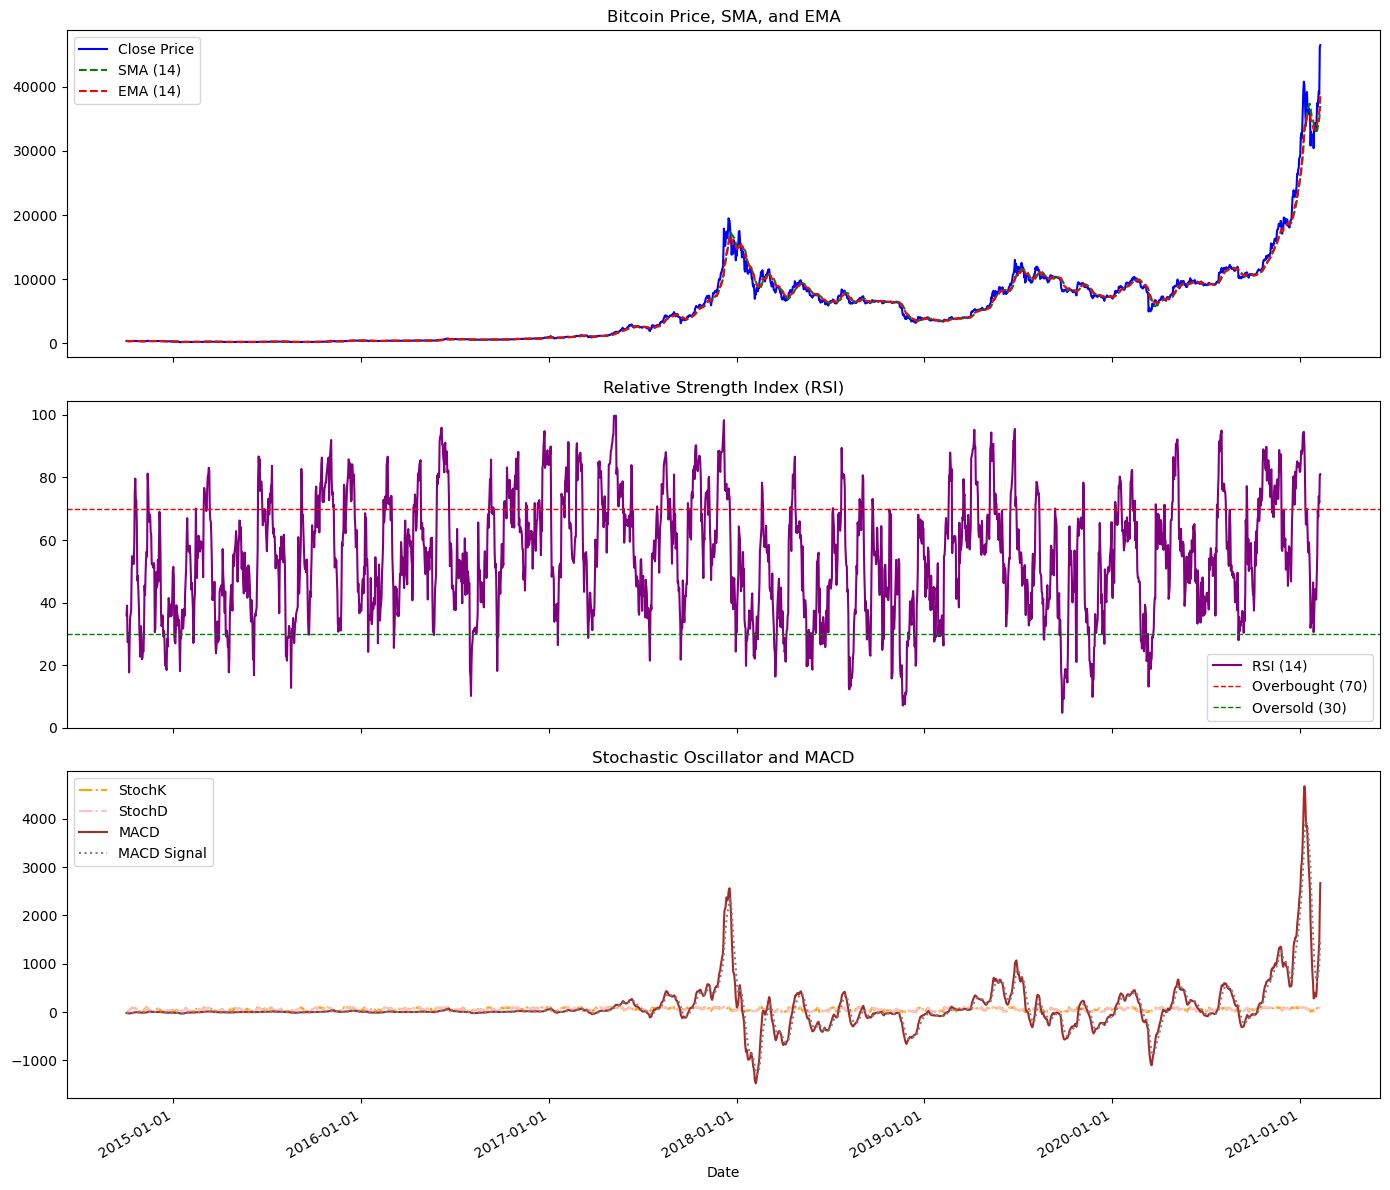

In [28]:
# Improved plotting with subplots for better visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot Closing Price, SMA, and EMA on ax1
ax1.plot(enhanced_bitcoin_data.index, enhanced_bitcoin_data['Close_Price'], label='Close Price', color='b')
ax1.plot(enhanced_bitcoin_data.index, enhanced_bitcoin_data['SMA_14'], label='SMA (14)', color='g', linestyle='--', linewidth=1.5)
ax1.plot(enhanced_bitcoin_data.index, enhanced_bitcoin_data['EMA_14'], label='EMA (14)', color='r', linestyle='--', linewidth=1.5)
ax1.set_title('Bitcoin Price, SMA, and EMA')
ax1.legend()

# Plot RSI on ax2
ax2.plot(enhanced_bitcoin_data.index, enhanced_bitcoin_data['RSI_14'], label='RSI (14)', color='purple', linewidth=1.5)
ax2.axhline(70, color='red', linestyle='--', linewidth=1, label="Overbought (70)")
ax2.axhline(30, color='green', linestyle='--', linewidth=1, label="Oversold (30)")
ax2.set_title('Relative Strength Index (RSI)')
ax2.legend()

# Plot Stochastic Oscillator and MACD on ax3
ax3.plot(enhanced_bitcoin_data.index, enhanced_bitcoin_data['StochK'], label='StochK', color='orange', linestyle='-.', linewidth=1.5)
ax3.plot(enhanced_bitcoin_data.index, enhanced_bitcoin_data['StochD'], label='StochD', color='pink', linestyle='-.', linewidth=1.5)
ax3.plot(enhanced_bitcoin_data.index, enhanced_bitcoin_data['MACD'], label='MACD', color='brown', linewidth=1.5)
ax3.plot(enhanced_bitcoin_data.index, enhanced_bitcoin_data['MACD_Signal'], label='MACD Signal', color='gray', linestyle=':', linewidth=1.5)
ax3.set_title('Stochastic Oscillator and MACD')
ax3.legend()

# Format x-axis to display proper dates
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.xaxis.set_major_locator(mdates.YearLocator())
fig.autofmt_xdate()
plt.xlabel('Date')
plt.tight_layout()
plt.show()


## MODEL DEVELOPMENT

# ARIMA Model Development code without sentiment


Optimized ARIMA Parameters: (3, 1, 3)
                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                 1858
Model:                 ARIMA(3, 1, 3)   Log Likelihood                1497.377
Date:                Fri, 10 Jan 2025   AIC                          -2932.754
Time:                        04:16:05   BIC                          -2761.426
Sample:                    10-02-2014   HQIC                         -2869.610
                         - 11-02-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -186.3194      1.303   -142.939      0.000    -188.874    -183.765
x2          5694.5751      2.131   2671.629      0.000    5690.397    5698.753
x3            

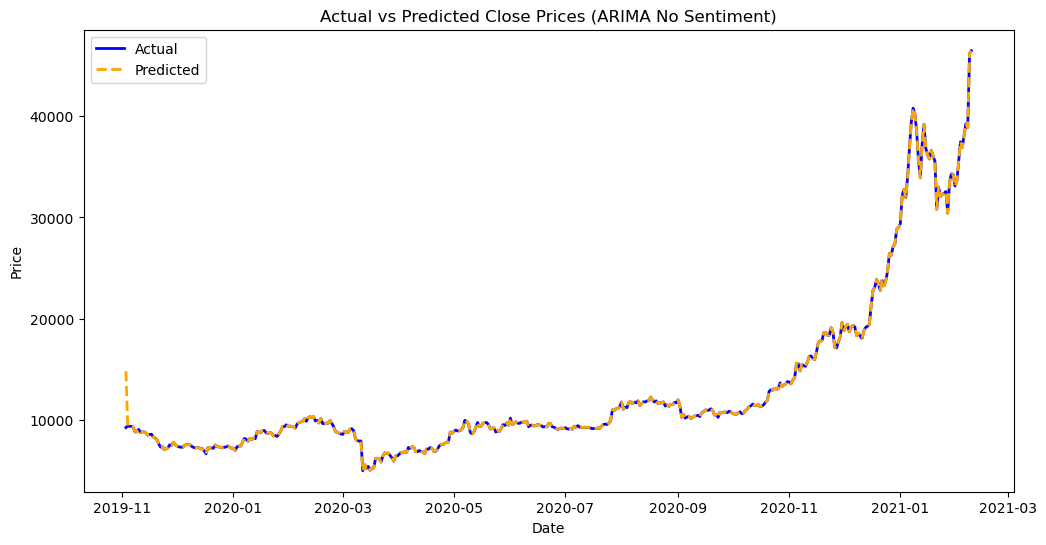

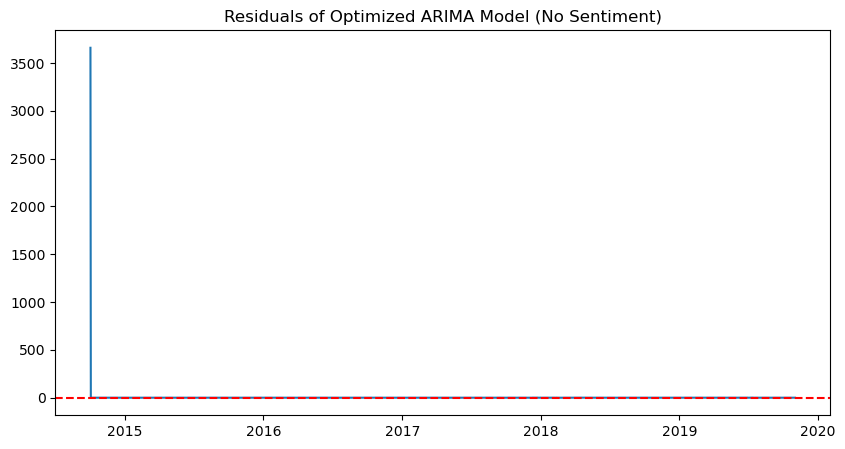

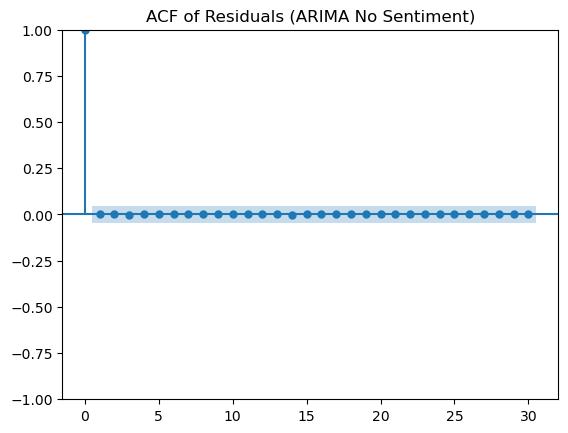

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from itertools import product
from joblib import Parallel, delayed
from statsmodels.graphics.tsaplots import plot_acf

# Step 1: Select Target Variable and Exogenous Features
target_variable_arima_no_sentiment = 'Close_Price'
exogenous_features_arima_no_sentiment = ['SMA_14', 'EMA_14', 'RSI_14', 'MACD']

# Train-Test Split
train_size = int(len(enhanced_bitcoin_data) * 0.8)
train_arima_no_sentiment, test_arima_no_sentiment = (
    enhanced_bitcoin_data[:train_size].copy(),
    enhanced_bitcoin_data[train_size:].copy(),
)

# Step 2: Feature Engineering - Create Lagged Features and Rolling Means
for feature in exogenous_features_arima_no_sentiment:
    for lag in [1, 3, 7, 14]:  # Adding more relevant lags
        train_arima_no_sentiment[f'{feature}_lag{lag}'] = train_arima_no_sentiment[feature].shift(lag)
        test_arima_no_sentiment[f'{feature}_lag{lag}'] = test_arima_no_sentiment[feature].shift(lag)
    # Adding rolling means
    train_arima_no_sentiment[f'{feature}_rolling7'] = train_arima_no_sentiment[feature].rolling(window=7).mean()
    test_arima_no_sentiment[f'{feature}_rolling7'] = test_arima_no_sentiment[feature].rolling(window=7).mean()

# Add lagged features to the exogenous features list
exogenous_features_arima_no_sentiment += [
    f'{feature}_lag{lag}' for feature in exogenous_features_arima_no_sentiment for lag in [1, 3, 7, 14]
]
exogenous_features_arima_no_sentiment += [
    f'{feature}_rolling7' for feature in ['SMA_14', 'EMA_14', 'RSI_14', 'MACD']
]

# Step 3: Normalize Exogenous Variables
scaler_arima_no_sentiment = StandardScaler()
train_exog_scaled_arima_no_sentiment = scaler_arima_no_sentiment.fit_transform(
    train_arima_no_sentiment[exogenous_features_arima_no_sentiment].fillna(0)
)
test_exog_scaled_arima_no_sentiment = scaler_arima_no_sentiment.transform(
    test_arima_no_sentiment[exogenous_features_arima_no_sentiment].fillna(0)
)

# Step 4: Define Model Hyperparameters
p = q = range(0, 4)  # Expanded range for AR and MA terms
d = [1]  # Differencing order

# Generate parameter combinations
param_combinations_arima_no_sentiment = list(product(p, d, q))

# Step 5: Define a Function to Fit ARIMA
def fit_arima_no_sentiment(params):
    try:
        order = (params[0], params[1], params[2])
        model = ARIMA(train_arima_no_sentiment[target_variable_arima_no_sentiment], order=order, exog=train_exog_scaled_arima_no_sentiment)
        model_fit = model.fit()
        return model_fit.aic, model_fit.bic, params, model_fit
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return float('inf'), float('inf'), params, None

# Step 6: Grid Search for Best Parameters
results_arima_no_sentiment = Parallel(n_jobs=-1)(
    delayed(fit_arima_no_sentiment)(params) for params in param_combinations_arima_no_sentiment
)
valid_results_arima_no_sentiment = [result for result in results_arima_no_sentiment if result[3] is not None]

if valid_results_arima_no_sentiment:
    best_aic_arima_no_sentiment, best_bic_arima_no_sentiment, best_params_arima_no_sentiment, best_model_arima_no_sentiment = min(
        valid_results_arima_no_sentiment, key=lambda x: (x[0], x[1])
    )
    print(f"Optimized ARIMA Parameters: {best_params_arima_no_sentiment}")
    print(best_model_arima_no_sentiment.summary())
else:
    print("No valid ARIMA model found.")
    best_model_arima_no_sentiment = None

# Step 7: Forecasting and Evaluation
if best_model_arima_no_sentiment is not None:
    predictions_arima_no_sentiment = best_model_arima_no_sentiment.forecast(
        steps=len(test_arima_no_sentiment), exog=test_exog_scaled_arima_no_sentiment
    )

    # Evaluation Metrics
    rmse_arima_no_sentiment = mean_squared_error(
        test_arima_no_sentiment[target_variable_arima_no_sentiment], predictions_arima_no_sentiment, squared=False
    )
    mae_arima_no_sentiment = mean_absolute_error(
        test_arima_no_sentiment[target_variable_arima_no_sentiment], predictions_arima_no_sentiment
    )
    mape_arima_no_sentiment = mean_absolute_percentage_error(
        test_arima_no_sentiment[target_variable_arima_no_sentiment], predictions_arima_no_sentiment
    )
    print(f"Optimized ARIMA RMSE: {rmse_arima_no_sentiment}")
    print(f"Optimized ARIMA MAE: {mae_arima_no_sentiment}")
    print(f"Optimized ARIMA MAPE: {mape_arima_no_sentiment}")

    # Plot Actual vs Predicted Prices
    plt.figure(figsize=(12, 6))
    plt.plot(test_arima_no_sentiment.index, test_arima_no_sentiment[target_variable_arima_no_sentiment], 
             label='Actual', color='blue', linewidth=2, linestyle='-')
    plt.plot(test_arima_no_sentiment.index, predictions_arima_no_sentiment, 
             label='Predicted', color='orange', linewidth=2, linestyle='--')
    plt.title('Actual vs Predicted Close Prices (ARIMA No Sentiment)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


    # Residual Analysis
    residuals_arima_no_sentiment = best_model_arima_no_sentiment.resid
    plt.figure(figsize=(10, 5))
    plt.plot(residuals_arima_no_sentiment)
    plt.title('Residuals of Optimized ARIMA Model (No Sentiment)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

    # ACF of Residuals
    plot_acf(residuals_arima_no_sentiment, lags=30)
    plt.title('ACF of Residuals (ARIMA No Sentiment)')
    plt.show()


#  SARIMA Model Development code without sentiment

Optimized SARIMA Parameters: (3, 1, 1, 1, 1, 0, 7)
                                     SARIMAX Results                                      
Dep. Variable:                        Close_Price   No. Observations:                 1858
Model:             SARIMAX(3, 1, 1)x(1, 1, [], 7)   Log Likelihood                1751.995
Date:                            Fri, 10 Jan 2025   AIC                          -3443.990
Time:                                    04:21:26   BIC                          -3278.464
Sample:                                10-02-2014   HQIC                         -3382.956
                                     - 11-02-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -133.5113      1.496    -89.244      0.000    -136.

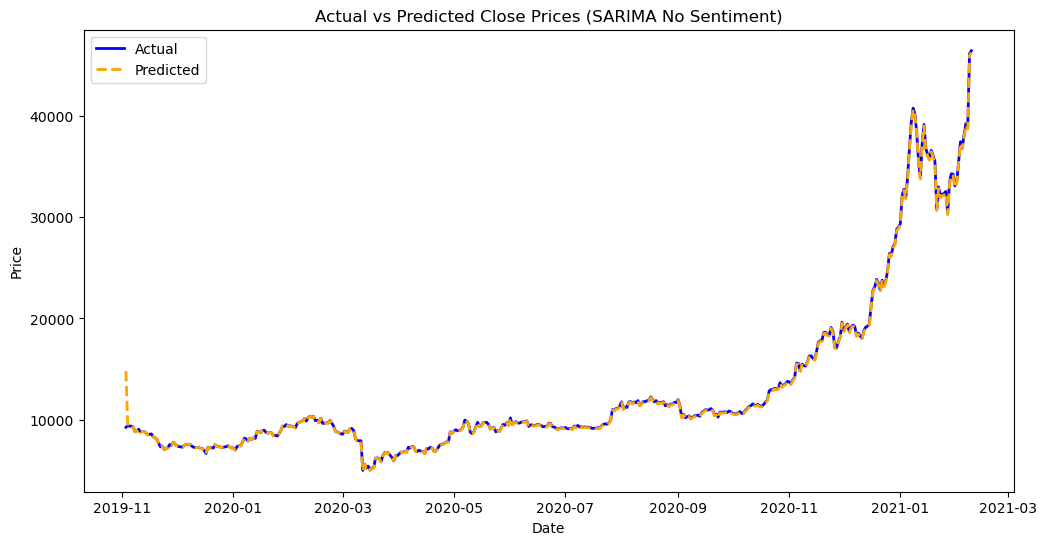

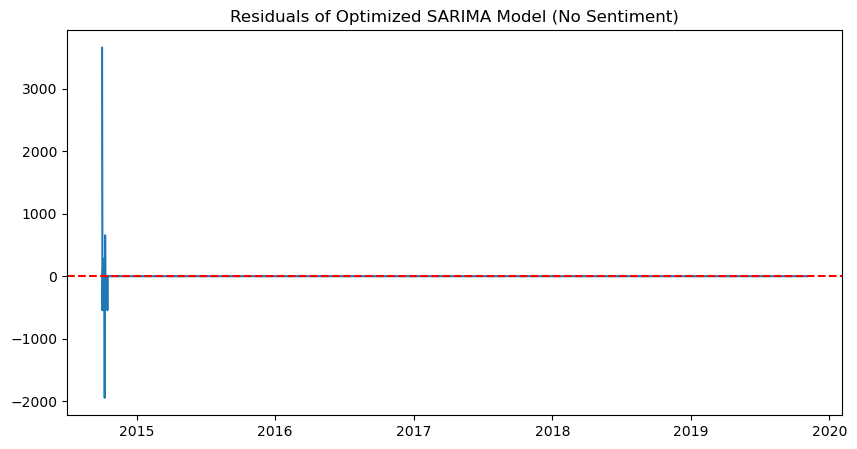

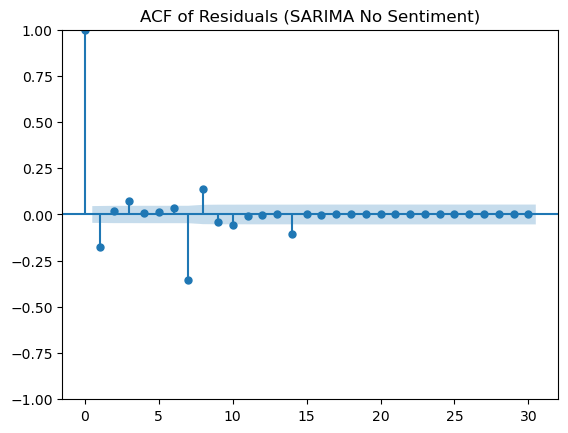

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from itertools import product
from joblib import Parallel, delayed
from statsmodels.graphics.tsaplots import plot_acf

# Step 1: Select Target Variable and Exogenous Features
target_variable_sarima_no_sentiment = 'Close_Price'
exogenous_features_sarima_no_sentiment = ['SMA_14', 'EMA_14', 'RSI_14', 'MACD']

# Train-Test Split
train_size = int(len(enhanced_bitcoin_data) * 0.8)
train_sarima_no_sentiment, test_sarima_no_sentiment = (
    enhanced_bitcoin_data[:train_size].copy(),
    enhanced_bitcoin_data[train_size:].copy(),
)

# Step 2: Feature Engineering - Create Lagged Features and Rolling Means
for feature in exogenous_features_sarima_no_sentiment:
    for lag in [1, 3, 7, 14]:  # Adding more relevant lags
        train_sarima_no_sentiment[f'{feature}_lag{lag}'] = train_sarima_no_sentiment[feature].shift(lag)
        test_sarima_no_sentiment[f'{feature}_lag{lag}'] = test_sarima_no_sentiment[feature].shift(lag)
    # Adding rolling means
    train_sarima_no_sentiment[f'{feature}_rolling7'] = train_sarima_no_sentiment[feature].rolling(window=7).mean()
    test_sarima_no_sentiment[f'{feature}_rolling7'] = test_sarima_no_sentiment[feature].rolling(window=7).mean()

# Add lagged features to the exogenous features list
exogenous_features_sarima_no_sentiment += [
    f'{feature}_lag{lag}' for feature in exogenous_features_sarima_no_sentiment for lag in [1, 3, 7, 14]
]
exogenous_features_sarima_no_sentiment += [
    f'{feature}_rolling7' for feature in ['SMA_14', 'EMA_14', 'RSI_14', 'MACD']
]

# Step 3: Normalize Exogenous Variables
scaler_sarima_no_sentiment = StandardScaler()
train_exog_scaled_sarima_no_sentiment = scaler_sarima_no_sentiment.fit_transform(
    train_sarima_no_sentiment[exogenous_features_sarima_no_sentiment].fillna(0)
)
test_exog_scaled_sarima_no_sentiment = scaler_sarima_no_sentiment.transform(
    test_sarima_no_sentiment[exogenous_features_sarima_no_sentiment].fillna(0)
)

# Step 4: Define SARIMA Hyperparameters
p = q = range(0, 4)  # AR and MA terms
d = [1]  # Differencing
P = Q = range(0, 2)  # Seasonal AR and MA terms
D = [1]  # Seasonal differencing
m = [7]  # Weekly seasonality

# Generate all parameter combinations
param_combinations_sarima_no_sentiment = list(product(p, d, q, P, D, Q, m))

# Step 5: Define a Function to Fit SARIMA
def fit_sarima_no_sentiment(params):
    try:
        order = (params[0], params[1], params[2])
        seasonal_order = (params[3], params[4], params[5], params[6])
        model = SARIMAX(
            train_sarima_no_sentiment[target_variable_sarima_no_sentiment],
            order=order,
            seasonal_order=seasonal_order,
            exog=train_exog_scaled_sarima_no_sentiment,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        model_fit = model.fit(disp=False)
        return model_fit.aic, model_fit.bic, params, model_fit
    except Exception as e:
        print(f"Error with params {params}: {e}")
        return float('inf'), float('inf'), params, None

# Step 6: Grid Search for Best Parameters
results_sarima_no_sentiment = Parallel(n_jobs=-1)(
    delayed(fit_sarima_no_sentiment)(params) for params in param_combinations_sarima_no_sentiment
)
valid_results_sarima_no_sentiment = [result for result in results_sarima_no_sentiment if result[3] is not None]

if valid_results_sarima_no_sentiment:
    best_aic_sarima_no_sentiment, best_bic_sarima_no_sentiment, best_params_sarima_no_sentiment, best_model_sarima_no_sentiment = min(
        valid_results_sarima_no_sentiment, key=lambda x: (x[0], x[1])
    )
    print(f"Optimized SARIMA Parameters: {best_params_sarima_no_sentiment}")
    print(best_model_sarima_no_sentiment.summary())
else:
    print("No valid SARIMA model found.")
    best_model_sarima_no_sentiment = None

# Step 7: Forecasting and Evaluation
if best_model_sarima_no_sentiment is not None:
    predictions_sarima_no_sentiment = best_model_sarima_no_sentiment.forecast(
        steps=len(test_sarima_no_sentiment), exog=test_exog_scaled_sarima_no_sentiment
    )

    # Evaluation Metrics
    rmse_sarima_no_sentiment = mean_squared_error(
        test_sarima_no_sentiment[target_variable_sarima_no_sentiment], predictions_sarima_no_sentiment, squared=False
    )
    mae_sarima_no_sentiment = mean_absolute_error(
        test_sarima_no_sentiment[target_variable_sarima_no_sentiment], predictions_sarima_no_sentiment
    )
    mape_sarima_no_sentiment = mean_absolute_percentage_error(
        test_sarima_no_sentiment[target_variable_sarima_no_sentiment], predictions_sarima_no_sentiment
    )
    print(f"Optimized SARIMA RMSE: {rmse_sarima_no_sentiment}")
    print(f"Optimized SARIMA MAE: {mae_sarima_no_sentiment}")
    print(f"Optimized SARIMA MAPE: {mape_sarima_no_sentiment}")

    # Plot Actual vs Predicted Prices
    plt.figure(figsize=(12, 6))
    plt.plot(test_sarima_no_sentiment.index, test_sarima_no_sentiment[target_variable_sarima_no_sentiment], label='Actual', color='blue', linewidth=2, linestyle='-')
    plt.plot(test_sarima_no_sentiment.index, predictions_sarima_no_sentiment, label='Predicted', color='orange', linewidth=2, linestyle='--')
    plt.title('Actual vs Predicted Close Prices (SARIMA No Sentiment)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Residual Analysis
    residuals_sarima_no_sentiment = best_model_sarima_no_sentiment.resid
    plt.figure(figsize=(10, 5))
    plt.plot(residuals_sarima_no_sentiment)
    plt.title('Residuals of Optimized SARIMA Model (No Sentiment)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

    # ACF of Residuals
    plot_acf(residuals_sarima_no_sentiment, lags=30)
    plt.title('ACF of Residuals (SARIMA No Sentiment)')
    plt.show()


# Sentiment Enhanced ARIMA Model Development Code

C:\Users\abuze\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.355e+06, tolerance: 2.174e+06
  model = cd_fast.enet_coordinate_descent(


Optimized ARIMA Parameters (With Sentiment): (0, 1, 1)
                               SARIMAX Results                                
Dep. Variable:            Close_Price   No. Observations:                 1626
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -4664.103
Date:                Fri, 10 Jan 2025   AIC                           9354.207
Time:                        04:23:04   BIC                           9424.319
Sample:                    10-02-2014   HQIC                          9380.221
                         - 03-15-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -161.9593     94.600     -1.712      0.087    -347.372      23.453
x2          3852.4195    103.576     37.194      0.000    3649.414    4055.4

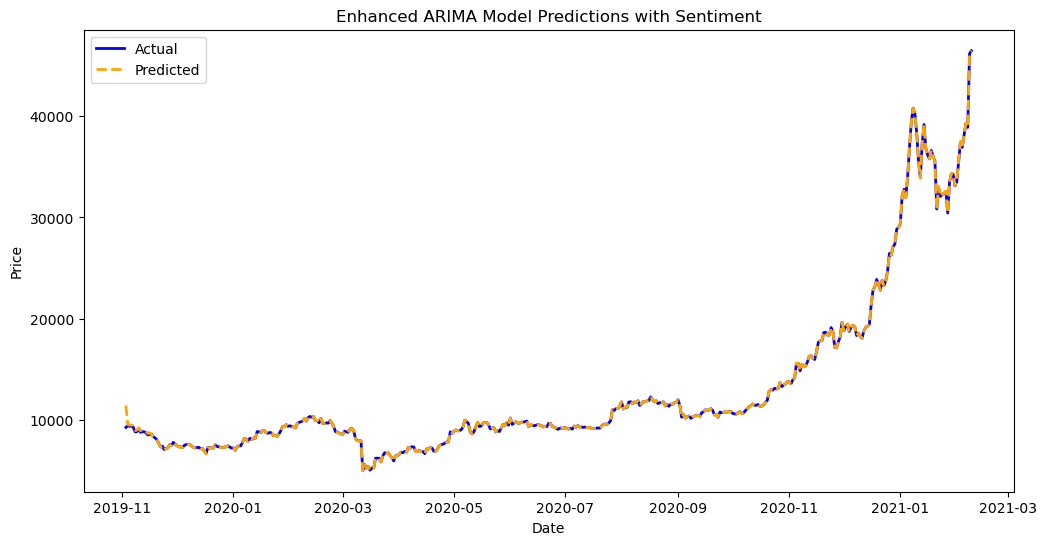

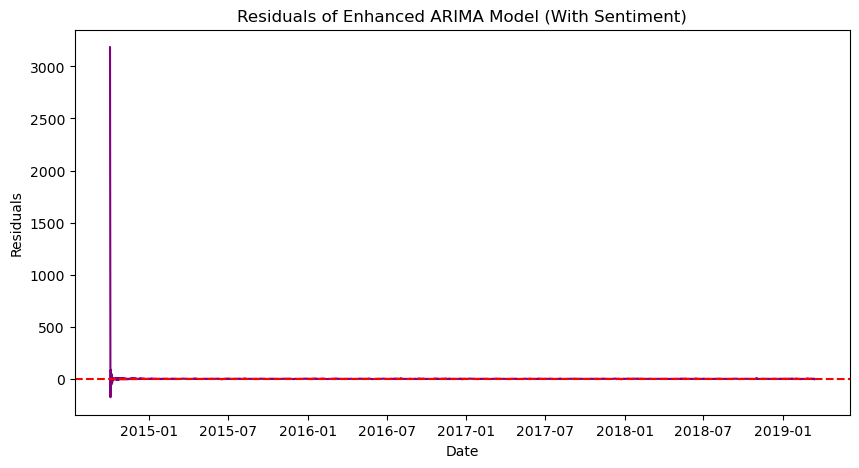

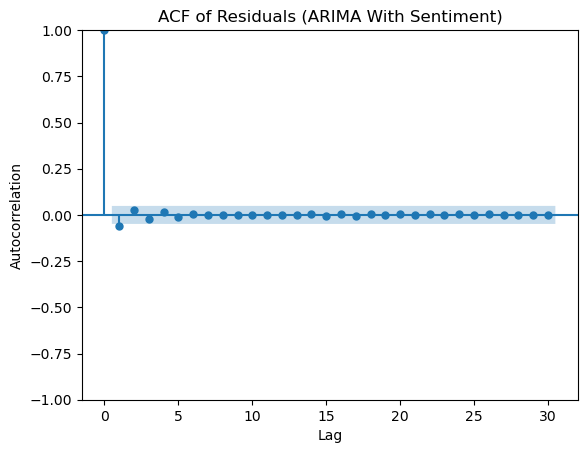

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from itertools import product
from joblib import Parallel, delayed
from statsmodels.graphics.tsaplots import plot_acf

# Load Bitcoin and Sentiment Data
bitcoin_data = enhanced_bitcoin_data.copy()
sentiment_data_path = "C:\\Users\\abuze\\OneDrive\\Desktop\\tweets_sentiment.csv"
sentiment_data = pd.read_csv(sentiment_data_path, low_memory=False)

# Convert 'date' to datetime and aggregate sentiment scores
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'], errors='coerce')
daily_sentiment = sentiment_data.groupby('date')[['neg', 'neu', 'pos', 'compound']].mean()

# Ensure Bitcoin data index is datetime
bitcoin_data.index = pd.to_datetime(bitcoin_data.index)

# Merge Bitcoin data with sentiment data
bitcoin_with_sentiment = bitcoin_data.merge(
    daily_sentiment, left_index=True, right_index=True, how='left'
)
bitcoin_with_sentiment[['neg', 'neu', 'pos', 'compound']] = bitcoin_with_sentiment[
    ['neg', 'neu', 'pos', 'compound']
].fillna(0)

# Define Target Variable and Exogenous Features
target_variable_arima_with_sentiment = 'Close_Price'
exogenous_features_arima_with_sentiment = ['SMA_14', 'EMA_14', 'RSI_14', 'MACD', 'neg', 'neu', 'pos', 'compound']

# Train-Validation-Test Split
train_size = int(len(bitcoin_with_sentiment) * 0.7)
val_size = int(len(bitcoin_with_sentiment) * 0.1)
train_arima_with_sentiment = bitcoin_with_sentiment[:train_size].copy()
validation_arima_with_sentiment = bitcoin_with_sentiment[train_size:train_size + val_size].copy()
test_arima_with_sentiment = bitcoin_with_sentiment[train_size + val_size:].copy()

# Feature Engineering
for feature in exogenous_features_arima_with_sentiment:
    for lag in [1, 7, 14]:
        train_arima_with_sentiment[f'{feature}_lag{lag}'] = train_arima_with_sentiment[feature].shift(lag)
        validation_arima_with_sentiment[f'{feature}_lag{lag}'] = validation_arima_with_sentiment[feature].shift(lag)
        test_arima_with_sentiment[f'{feature}_lag{lag}'] = test_arima_with_sentiment[feature].shift(lag)
    train_arima_with_sentiment[f'{feature}_rolling7'] = train_arima_with_sentiment[feature].rolling(window=7).mean()
    validation_arima_with_sentiment[f'{feature}_rolling7'] = validation_arima_with_sentiment[feature].rolling(window=7).mean()
    test_arima_with_sentiment[f'{feature}_rolling7'] = test_arima_with_sentiment[feature].rolling(window=7).mean()

# Update Features
lagged_features_arima_with_sentiment = [f'{feature}_lag{lag}' for feature in exogenous_features_arima_with_sentiment for lag in [1, 7, 14]]
rolling_features_arima_with_sentiment = [f'{feature}_rolling7' for feature in exogenous_features_arima_with_sentiment]
exogenous_features_arima_with_sentiment += lagged_features_arima_with_sentiment + rolling_features_arima_with_sentiment

# Feature Selection with Lasso
train_exog_arima_with_sentiment = train_arima_with_sentiment[exogenous_features_arima_with_sentiment].fillna(0)
validation_exog_arima_with_sentiment = validation_arima_with_sentiment[exogenous_features_arima_with_sentiment].fillna(0)
test_exog_arima_with_sentiment = test_arima_with_sentiment[exogenous_features_arima_with_sentiment].fillna(0)

scaler_arima_with_sentiment = StandardScaler()
train_exog_scaled_arima_with_sentiment = scaler_arima_with_sentiment.fit_transform(train_exog_arima_with_sentiment)
validation_exog_scaled_arima_with_sentiment = scaler_arima_with_sentiment.transform(validation_exog_arima_with_sentiment)
test_exog_scaled_arima_with_sentiment = scaler_arima_with_sentiment.transform(test_exog_arima_with_sentiment)

lasso = LassoCV(cv=5, random_state=42).fit(train_exog_scaled_arima_with_sentiment, train_arima_with_sentiment[target_variable_arima_with_sentiment])
selected_features_idx_arima_with_sentiment = SelectFromModel(lasso, prefit=True).get_support(indices=True)
train_exog_scaled_arima_with_sentiment = train_exog_scaled_arima_with_sentiment[:, selected_features_idx_arima_with_sentiment]
validation_exog_scaled_arima_with_sentiment = validation_exog_scaled_arima_with_sentiment[:, selected_features_idx_arima_with_sentiment]
test_exog_scaled_arima_with_sentiment = test_exog_scaled_arima_with_sentiment[:, selected_features_idx_arima_with_sentiment]

# ARIMA Hyperparameters
p = q = range(0, 4)
d = [1]
param_combinations_arima_with_sentiment = list(product(p, d, q))

# Define ARIMA Fit Function
def fit_arima_with_sentiment(params):
    try:
        order = (params[0], params[1], params[2])
        model = ARIMA(train_arima_with_sentiment[target_variable_arima_with_sentiment], order=order, exog=train_exog_scaled_arima_with_sentiment)
        model_fit = model.fit()
        val_predictions = model_fit.forecast(steps=len(validation_arima_with_sentiment), exog=validation_exog_scaled_arima_with_sentiment)
        val_rmse = mean_squared_error(validation_arima_with_sentiment[target_variable_arima_with_sentiment], val_predictions, squared=False)
        return val_rmse, params, model_fit
    except Exception as e:
        return float('inf'), params, None

# Grid Search for Best Parameters
results_arima_with_sentiment = Parallel(n_jobs=-1)(delayed(fit_arima_with_sentiment)(params) for params in param_combinations_arima_with_sentiment)
valid_results_arima_with_sentiment = [result for result in results_arima_with_sentiment if result[2] is not None]

if valid_results_arima_with_sentiment:
    best_rmse_arima_with_sentiment, best_params_arima_with_sentiment, best_model_arima_with_sentiment = min(valid_results_arima_with_sentiment, key=lambda x: x[0])
    print(f"Optimized ARIMA Parameters (With Sentiment): {best_params_arima_with_sentiment}")
    print(best_model_arima_with_sentiment.summary())
else:
    print("No valid ARIMA model found (With Sentiment).")
    best_model_arima_with_sentiment = None

# Forecasting and Evaluation
if best_model_arima_with_sentiment is not None:
    predictions_arima_with_sentiment = best_model_arima_with_sentiment.forecast(steps=len(test_arima_with_sentiment), exog=test_exog_scaled_arima_with_sentiment)
    rmse_arima_with_sentiment = mean_squared_error(test_arima_with_sentiment[target_variable_arima_with_sentiment], predictions_arima_with_sentiment, squared=False)
    mae_arima_with_sentiment = mean_absolute_error(test_arima_with_sentiment[target_variable_arima_with_sentiment], predictions_arima_with_sentiment)
    mape_arima_with_sentiment = mean_absolute_percentage_error(test_arima_with_sentiment[target_variable_arima_with_sentiment], predictions_arima_with_sentiment)

    print(f"Test RMSE (ARIMA With Sentiment): {rmse_arima_with_sentiment}")
    print(f"Test MAE (ARIMA With Sentiment): {mae_arima_with_sentiment}")
    print(f"Test MAPE (ARIMA With Sentiment): {mape_arima_with_sentiment}")

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test_arima_with_sentiment.index, test_arima_with_sentiment[target_variable_arima_with_sentiment], label='Actual', color='blue', linewidth=2, linestyle='-')
    plt.plot(test_arima_with_sentiment.index, predictions_arima_with_sentiment, label='Predicted', color='orange', linewidth=2, linestyle='--')
    plt.title('Enhanced ARIMA Model Predictions with Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Residual Analysis
    residuals_arima_with_sentiment = best_model_arima_with_sentiment.resid
    plt.figure(figsize=(10, 5))
    plt.plot(residuals_arima_with_sentiment, color='purple')
    plt.title('Residuals of Enhanced ARIMA Model (With Sentiment)')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.show()

    # ACF Plot for Residuals
    plot_acf(residuals_arima_with_sentiment, lags=30, alpha=0.05)
    plt.title('ACF of Residuals (ARIMA With Sentiment)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()


# Sentiment Enhanced SARIMA Model Development Code

C:\Users\abuze\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.355e+06, tolerance: 2.174e+06
  model = cd_fast.enet_coordinate_descent(


Optimized SARIMA Parameters (With Sentiment): (1, 1, 2, 1, 1, 1, 7)
                                      SARIMAX Results                                      
Dep. Variable:                         Close_Price   No. Observations:                 1626
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 7)   Log Likelihood                 288.659
Date:                             Fri, 10 Jan 2025   AIC                           -543.318
Time:                                     04:24:41   BIC                           -451.812
Sample:                                 10-02-2014   HQIC                          -509.347
                                      - 03-15-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -94.3152      1.782    -5

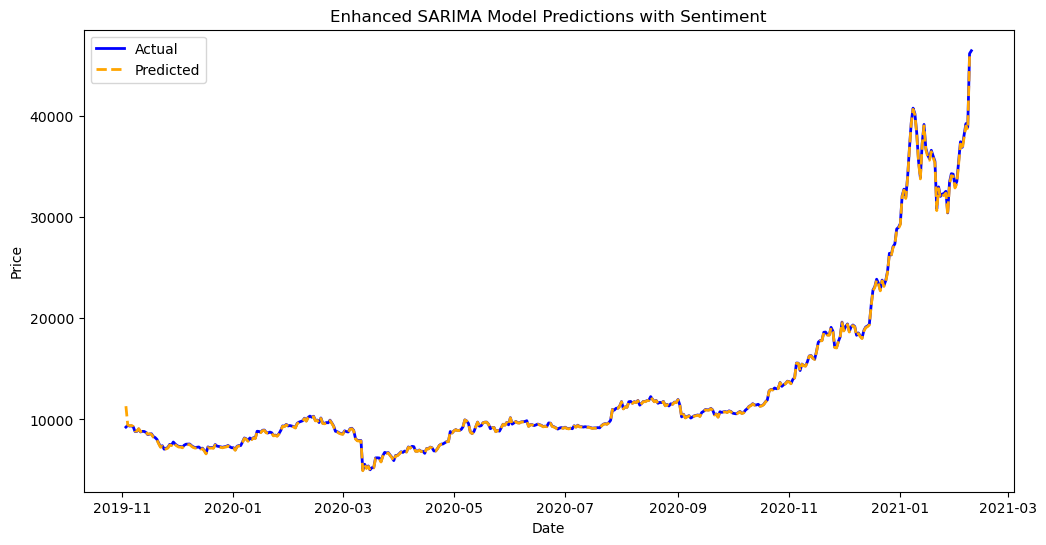

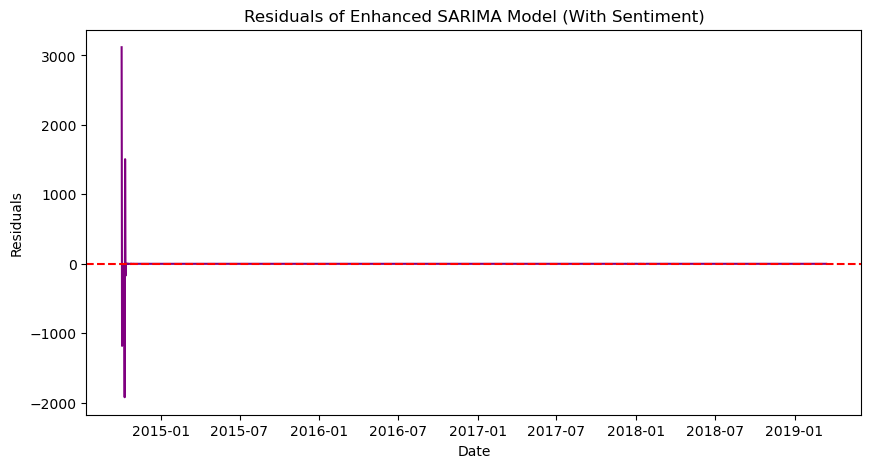

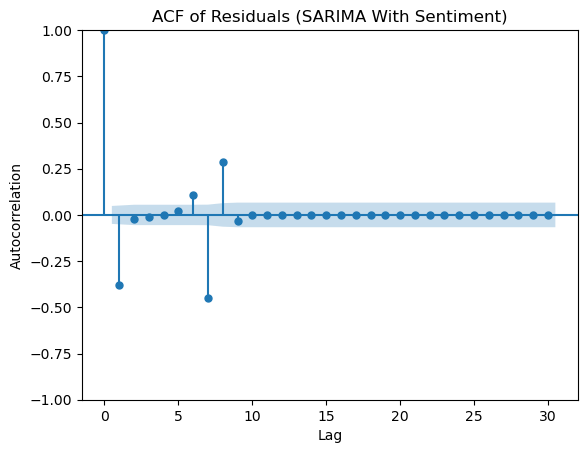

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from itertools import product
from statsmodels.stats.stattools import durbin_watson
from joblib import Parallel, delayed
from statsmodels.graphics.tsaplots import plot_acf

# Load Bitcoin and Sentiment Data
bitcoin_data = enhanced_bitcoin_data.copy()
sentiment_data_path = "C:\\Users\\abuze\\OneDrive\\Desktop\\tweets_sentiment.csv"
sentiment_data = pd.read_csv(sentiment_data_path, low_memory=False)

# Convert 'date' to datetime and aggregate sentiment scores
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'], errors='coerce')
daily_sentiment = sentiment_data.groupby('date')[['neg', 'neu', 'pos', 'compound']].mean()

# Ensure Bitcoin data index is datetime
bitcoin_data.index = pd.to_datetime(bitcoin_data.index)

# Merge Bitcoin data with sentiment data
bitcoin_with_sentiment = bitcoin_data.merge(
    daily_sentiment, left_index=True, right_index=True, how='left'
)
bitcoin_with_sentiment[['neg', 'neu', 'pos', 'compound']] = bitcoin_with_sentiment[
    ['neg', 'neu', 'pos', 'compound']
].fillna(0)

# Define Target Variable and Exogenous Features
target_variable_sarima_with_sentiment = 'Close_Price'
exogenous_features_sarima_with_sentiment = ['SMA_14', 'EMA_14', 'RSI_14', 'MACD', 'neg', 'neu', 'pos', 'compound']

# Train-Validation-Test Split
train_size = int(len(bitcoin_with_sentiment) * 0.7)
val_size = int(len(bitcoin_with_sentiment) * 0.1)
train_sarima_with_sentiment = bitcoin_with_sentiment[:train_size].copy()
validation_sarima_with_sentiment = bitcoin_with_sentiment[train_size:train_size + val_size].copy()
test_sarima_with_sentiment = bitcoin_with_sentiment[train_size + val_size:].copy()

# Feature Engineering
for feature in exogenous_features_sarima_with_sentiment:
    for lag in [1, 7, 14]:
        train_sarima_with_sentiment[f'{feature}_lag{lag}'] = train_sarima_with_sentiment[feature].shift(lag)
        validation_sarima_with_sentiment[f'{feature}_lag{lag}'] = validation_sarima_with_sentiment[feature].shift(lag)
        test_sarima_with_sentiment[f'{feature}_lag{lag}'] = test_sarima_with_sentiment[feature].shift(lag)
    train_sarima_with_sentiment[f'{feature}_rolling7'] = train_sarima_with_sentiment[feature].rolling(window=7).mean()
    validation_sarima_with_sentiment[f'{feature}_rolling7'] = validation_sarima_with_sentiment[feature].rolling(window=7).mean()
    test_sarima_with_sentiment[f'{feature}_rolling7'] = test_sarima_with_sentiment[feature].rolling(window=7).mean()

# Update Features
lagged_features_sarima_with_sentiment = [f'{feature}_lag{lag}' for feature in exogenous_features_sarima_with_sentiment for lag in [1, 7, 14]]
rolling_features_sarima_with_sentiment = [f'{feature}_rolling7' for feature in exogenous_features_sarima_with_sentiment]
exogenous_features_sarima_with_sentiment += lagged_features_sarima_with_sentiment + rolling_features_sarima_with_sentiment

# Feature Selection with Lasso
train_exog_sarima_with_sentiment = train_sarima_with_sentiment[exogenous_features_sarima_with_sentiment].fillna(0)
validation_exog_sarima_with_sentiment = validation_sarima_with_sentiment[exogenous_features_sarima_with_sentiment].fillna(0)
test_exog_sarima_with_sentiment = test_sarima_with_sentiment[exogenous_features_sarima_with_sentiment].fillna(0)

scaler_sarima_with_sentiment = StandardScaler()
train_exog_scaled_sarima_with_sentiment = scaler_sarima_with_sentiment.fit_transform(train_exog_sarima_with_sentiment)
validation_exog_scaled_sarima_with_sentiment = scaler_sarima_with_sentiment.transform(validation_exog_sarima_with_sentiment)
test_exog_scaled_sarima_with_sentiment = scaler_sarima_with_sentiment.transform(test_exog_sarima_with_sentiment)

lasso = LassoCV(cv=5, random_state=42).fit(train_exog_scaled_sarima_with_sentiment, train_sarima_with_sentiment[target_variable_sarima_with_sentiment])
selected_features_idx_sarima_with_sentiment = SelectFromModel(lasso, prefit=True).get_support(indices=True)
train_exog_scaled_sarima_with_sentiment = train_exog_scaled_sarima_with_sentiment[:, selected_features_idx_sarima_with_sentiment]
validation_exog_scaled_sarima_with_sentiment = validation_exog_scaled_sarima_with_sentiment[:, selected_features_idx_sarima_with_sentiment]
test_exog_scaled_sarima_with_sentiment = test_exog_scaled_sarima_with_sentiment[:, selected_features_idx_sarima_with_sentiment]

# SARIMA Hyperparameters
p = q = range(0, 3)
d = [1]
P = Q = range(0, 2)
D = [1]
m = [7]
param_combinations_sarima_with_sentiment = list(product(p, d, q, P, D, Q, m))

# Define SARIMA Fit Function
def fit_sarima_with_sentiment(params):
    try:
        order = (params[0], params[1], params[2])
        seasonal_order = (params[3], params[4], params[5], params[6])
        model = SARIMAX(
            train_sarima_with_sentiment[target_variable_sarima_with_sentiment],
            order=order,
            seasonal_order=seasonal_order,
            exog=train_exog_scaled_sarima_with_sentiment,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        model_fit = model.fit(disp=False)
        val_predictions = model_fit.forecast(steps=len(validation_sarima_with_sentiment), exog=validation_exog_scaled_sarima_with_sentiment)
        val_rmse = mean_squared_error(validation_sarima_with_sentiment[target_variable_sarima_with_sentiment], val_predictions, squared=False)
        return val_rmse, params, model_fit
    except Exception as e:
        return float('inf'), params, None

# Grid Search for Best Parameters
results_sarima_with_sentiment = Parallel(n_jobs=-1)(delayed(fit_sarima_with_sentiment)(params) for params in param_combinations_sarima_with_sentiment)
valid_results_sarima_with_sentiment = [result for result in results_sarima_with_sentiment if result[2] is not None]

if valid_results_sarima_with_sentiment:
    best_rmse_sarima_with_sentiment, best_params_sarima_with_sentiment, best_model_sarima_with_sentiment = min(valid_results_sarima_with_sentiment, key=lambda x: x[0])
    print(f"Optimized SARIMA Parameters (With Sentiment): {best_params_sarima_with_sentiment}")
    print(best_model_sarima_with_sentiment.summary())
else:
    print("No valid SARIMA model found (With Sentiment).")
    best_model_sarima_with_sentiment = None

# Forecasting and Evaluation
if best_model_sarima_with_sentiment is not None:
    predictions_sarima_with_sentiment = best_model_sarima_with_sentiment.forecast(steps=len(test_sarima_with_sentiment), exog=test_exog_scaled_sarima_with_sentiment)
    rmse_sarima_with_sentiment = mean_squared_error(test_sarima_with_sentiment[target_variable_sarima_with_sentiment], predictions_sarima_with_sentiment, squared=False)
    mae_sarima_with_sentiment = mean_absolute_error(test_sarima_with_sentiment[target_variable_sarima_with_sentiment], predictions_sarima_with_sentiment)
    mape_sarima_with_sentiment = mean_absolute_percentage_error(test_sarima_with_sentiment[target_variable_sarima_with_sentiment], predictions_sarima_with_sentiment)

    print(f"Test RMSE (SARIMA With Sentiment): {rmse_sarima_with_sentiment}")
    print(f"Test MAE (SARIMA With Sentiment): {mae_sarima_with_sentiment}")
    print(f"Test MAPE (SARIMA With Sentiment): {mape_sarima_with_sentiment}")

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(test_sarima_with_sentiment.index, test_sarima_with_sentiment[target_variable_sarima_with_sentiment], label='Actual', color='blue', linewidth=2, linestyle='-')
    plt.plot(test_sarima_with_sentiment.index, predictions_sarima_with_sentiment, label='Predicted', color='orange', linewidth=2, linestyle='--')
    plt.title('Enhanced SARIMA Model Predictions with Sentiment')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Residual Analysis
    residuals_sarima_with_sentiment = best_model_sarima_with_sentiment.resid
    plt.figure(figsize=(10, 5))
    plt.plot(residuals_sarima_with_sentiment, color='purple')
    plt.title('Residuals of Enhanced SARIMA Model (With Sentiment)')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.show()

    # ACF Plot for Residuals
    plot_acf(residuals_sarima_with_sentiment, lags=30, alpha=0.05)
    plt.title('ACF of Residuals (SARIMA With Sentiment)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()




# Model Evaluation


                     Model        RMSE        MAE      MAPE
0     ARIMA (No Sentiment)  258.283202  15.041009  0.001561
1   ARIMA (With Sentiment)  103.621108  16.365447  0.001708
2    SARIMA (No Sentiment)  266.279551  66.630522  0.005320
3  SARIMA (With Sentiment)  115.765499  52.287409  0.004317


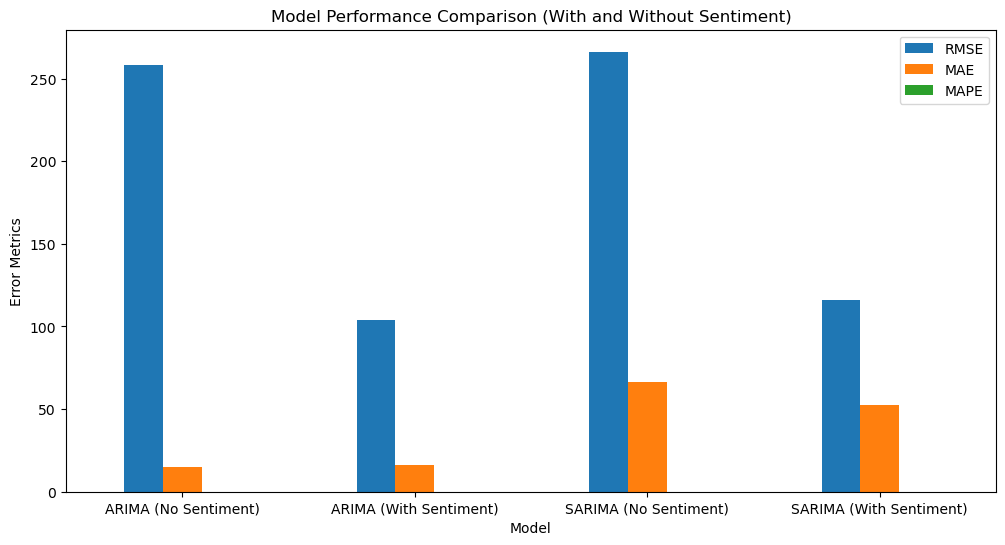

In [33]:
# Compile performance metrics for all models
model_comparison_data = {
    "Model": ["ARIMA (No Sentiment)", "ARIMA (With Sentiment)", "SARIMA (No Sentiment)", "SARIMA (With Sentiment)"],
    "RMSE": [rmse_arima_no_sentiment, rmse_arima_with_sentiment, rmse_sarima_no_sentiment, rmse_sarima_with_sentiment],
    "MAE": [mae_arima_no_sentiment, mae_arima_with_sentiment, mae_sarima_no_sentiment, mae_sarima_with_sentiment],
    "MAPE": [mape_arima_no_sentiment, mape_arima_with_sentiment, mape_sarima_no_sentiment, mape_sarima_with_sentiment],
}

performance_df = pd.DataFrame(model_comparison_data)

# Display the performance comparison
print(performance_df)

# Bar plot for performance comparison
performance_df.set_index("Model").plot(kind="bar", figsize=(12, 6), rot=0)
plt.title("Model Performance Comparison (With and Without Sentiment)")
plt.ylabel("Error Metrics")
plt.legend(["RMSE", "MAE", "MAPE"])
plt.show()


# Error reduction metrics

In [34]:
# Calculate percentage improvement
arima_rmse_reduction = ((rmse_arima_no_sentiment - rmse_arima_with_sentiment) / rmse_arima_no_sentiment) * 100
sarima_rmse_reduction = ((rmse_sarima_no_sentiment - rmse_sarima_with_sentiment) / rmse_sarima_no_sentiment) * 100

arima_mae_reduction = ((mae_arima_no_sentiment - mae_arima_with_sentiment) / mae_arima_no_sentiment) * 100
sarima_mae_reduction = ((mae_sarima_no_sentiment - mae_sarima_with_sentiment) / mae_sarima_no_sentiment) * 100

print(f"ARIMA RMSE Reduction: {arima_rmse_reduction:.2f}%")
print(f"ARIMA MAE Reduction: {arima_mae_reduction:.2f}%")
print(f"SARIMA RMSE Reduction: {sarima_rmse_reduction:.2f}%")
print(f"SARIMA MAE Reduction: {sarima_mae_reduction:.2f}%")


ARIMA RMSE Reduction: 59.88%
ARIMA MAE Reduction: -8.81%
SARIMA RMSE Reduction: 56.52%
SARIMA MAE Reduction: 21.53%


In [35]:
# Calculate percentage improvement for RMSE
arima_rmse_reduction = ((rmse_arima_no_sentiment - rmse_arima_with_sentiment) / rmse_arima_no_sentiment) * 100
sarima_rmse_reduction = ((rmse_sarima_no_sentiment - rmse_sarima_with_sentiment) / rmse_sarima_no_sentiment) * 100

# Calculate percentage improvement for MAE
arima_mae_reduction = ((mae_arima_no_sentiment - mae_arima_with_sentiment) / mae_arima_no_sentiment) * 100
sarima_mae_reduction = ((mae_sarima_no_sentiment - mae_sarima_with_sentiment) / mae_sarima_no_sentiment) * 100

# Calculate percentage improvement for MAPE
arima_mape_reduction = ((mape_arima_no_sentiment - mape_arima_with_sentiment) / mape_arima_no_sentiment) * 100
sarima_mape_reduction = ((mape_sarima_no_sentiment - mape_sarima_with_sentiment) / mape_sarima_no_sentiment) * 100

# Print results
print(f"ARIMA RMSE Reduction: {arima_rmse_reduction:.2f}%")
print(f"ARIMA MAE Reduction: {arima_mae_reduction:.2f}%")
print(f"ARIMA MAPE Reduction: {arima_mape_reduction:.2f}%")
print(f"SARIMA RMSE Reduction: {sarima_rmse_reduction:.2f}%")
print(f"SARIMA MAE Reduction: {sarima_mae_reduction:.2f}%")
print(f"SARIMA MAPE Reduction: {sarima_mape_reduction:.2f}%")


ARIMA RMSE Reduction: 59.88%
ARIMA MAE Reduction: -8.81%
ARIMA MAPE Reduction: -9.46%
SARIMA RMSE Reduction: 56.52%
SARIMA MAE Reduction: 21.53%
SARIMA MAPE Reduction: 18.85%


# Feature importance analysis

In [36]:
# Extract selected sentiment features
selected_features_arima = [exogenous_features_arima_with_sentiment[i] for i in selected_features_idx_arima_with_sentiment]
selected_sentiment_features_arima = [feat for feat in selected_features_arima if "neg" in feat or "neu" in feat or "pos" in feat or "compound" in feat]

selected_features_sarima = [exogenous_features_sarima_with_sentiment[i] for i in selected_features_idx_sarima_with_sentiment]
selected_sentiment_features_sarima = [feat for feat in selected_features_sarima if "neg" in feat or "neu" in feat or "pos" in feat or "compound" in feat]

print(f"Sentiment Features in ARIMA Model: {selected_sentiment_features_arima}")
print(f"Sentiment Features in SARIMA Model: {selected_sentiment_features_sarima}")


Sentiment Features in ARIMA Model: ['compound_rolling7']
Sentiment Features in SARIMA Model: ['compound_rolling7']


# Correlation Analysis

             Close_Price       neg       neu       pos  compound
Close_Price     1.000000  0.165319 -0.035468  0.109590  0.270515
neg             0.165319  1.000000 -0.165692 -0.004975 -0.417260
neu            -0.035468 -0.165692  1.000000 -0.200778 -0.071535
pos             0.109590 -0.004975 -0.200778  1.000000  0.761932
compound        0.270515 -0.417260 -0.071535  0.761932  1.000000


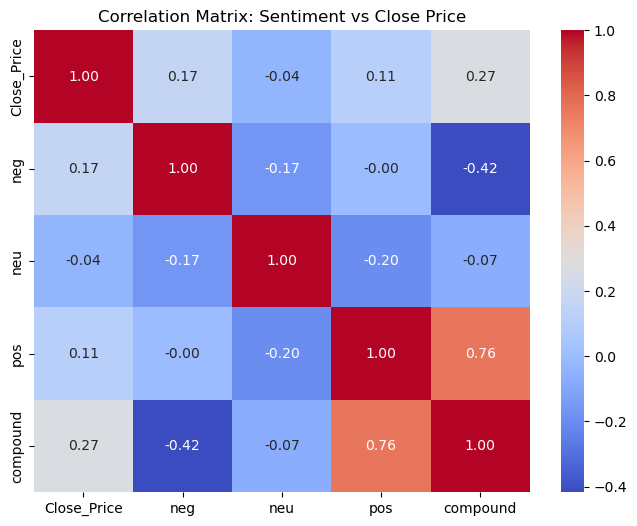

In [37]:
# Calculate correlations for sentiment variables
correlation_matrix = bitcoin_with_sentiment[['Close_Price', 'neg', 'neu', 'pos', 'compound']].corr()
print(correlation_matrix)

# Visualize correlations
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Sentiment vs Close Price")
plt.show()
